# CNN models on distributions

In [191]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append("../src/")
from collections import OrderedDict
import cellbell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [192]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import json

from models import conv1D_distribution, conv2D_distribution
from keras_tqdm import TQDMNotebookCallback
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot
from sklearn.model_selection import train_test_split
from hyperopt import fmin, tpe, hp, STATUS_OK

In [193]:
data_file = "../data/processed/ensemble-data.h5"
identifiers = pd.read_hdf(data_file, "predictions/identifiers")
one_week = pd.read_hdf(data_file, "predictions/one_week")
two_weeks = pd.read_hdf(data_file, "predictions/two_weeks")
three_weeks = pd.read_hdf(data_file, "predictions/three_weeks")
four_weeks = pd.read_hdf(data_file, "predictions/four_weeks")

wk_ahead_predictions = [one_week, two_weeks, three_weeks, four_weeks]
actual = pd.read_hdf(data_file, "actual")

## Mix models for a prediction week

In [194]:
week = 3 # from 0 to 3
week_targets = ["one-week", "two-weeks", "three-weeks", "four-weeks"]

# Get common identifiers
df = pd.concat([identifiers, wk_ahead_predictions[week]], axis=1)

df["key"] = df["time"].map(str) + df["region"]
models = ["kde", "kcde", "sarima"]

intersection = np.intersect1d(df[df["model"] == models[0]]["key"],
                              df[df["model"] == models[1]]["key"])
intersection = np.intersect1d(intersection, df[df["model"] == models[2]]["key"])

df = df[df["key"].isin(intersection)]
df = df.drop("key", axis=1)

# Shift actual to handle one week ahead prediction
actual["time"] = actual["time"] - 1 - week
df = pd.merge(actual, df, how="inner", on=["region", "time"])

df = df.sort_values(["model", "region", "time"])

In [195]:
kcde = df[df["model"] == "kcde"]
kde = df[df["model"] == "kde"]
sarima = df[df["model"] == "sarima"]

assert kcde.shape == kde.shape == sarima.shape

### Convert y to categories

In [196]:
n_bins = 131 # from 0 to 13 in steps of 0.1
bins = np.linspace(0, 13, num=n_bins)
Y = np.zeros((len(kcde), n_bins))

for i, elem in enumerate(kcde["actual"]):
    index = np.sum(elem > bins) - 1
    Y[i, index] = 1

In [197]:
X = np.exp(np.stack([kcde.iloc[:, 4:], kde.iloc[:, 4:], sarima.iloc[:, 4:]], axis=-1))

In [198]:
X_week = kcde["time"].as_matrix() % 100

### Training

In [199]:
X_train, X_test, X_week_train, X_week_test, Y_train, Y_test = train_test_split(X, X_week, Y,
                                                                               test_size=0.2, random_state=1234)

In [200]:
# Load pretrained embeddings
emb = np.load("../data/processed/week_embeddings.npy")

In [201]:
model = conv1D_distribution(3, n_bins, 20)
modelEmb = conv1D_distribution(3, n_bins, 20, week_embedding_matrix=emb)

In [202]:
# model.summary()

In [203]:
# modelEmb.summary()

In [204]:
model.compile(optimizer="adam", loss="categorical_crossentropy")
modelEmb.compile(optimizer="adam", loss="categorical_crossentropy")

In [205]:
history = model.fit([X_train, X_week_train], Y_train,
                    batch_size=64, nb_epoch=25,
                    verbose=0, callbacks=[TQDMNotebookCallback()],
                    validation_split=0.2)

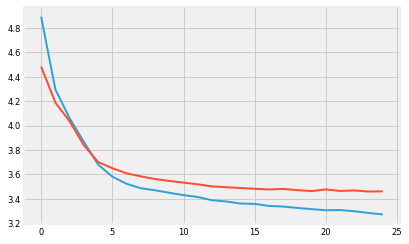

In [206]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])

In [207]:
history = modelEmb.fit([X_train, X_week_train], Y_train,
                       batch_size=64, nb_epoch=25,
                       verbose=0, callbacks=[TQDMNotebookCallback()],
                       validation_split=0.2)

In [208]:
# plt.plot(history.history["loss"])
# plt.plot(history.history["val_loss"])

In [209]:
out = model.predict([X_test, X_week_test])
outEmb = modelEmb.predict([X_test, X_week_test])

In [210]:
# for i in range(10):
#     index = np.random.randint(0, len(out))
#     plt.figure(figsize=(10, 7))
#     plt.axvline(x=bins[np.where(Y_test[index] == 1)[0][0]], linewidth=5, color="k", alpha=0.2)
#     plt.plot(bins, X_test[index][:, 0], linestyle="--", label="kcde")
#     plt.plot(bins, X_test[index][:, 1], linestyle="--", label="kde")
#     plt.plot(bins, X_test[index][:, 2], linestyle="--", label="sarima")
#     plt.plot(bins, out[index], color="k", alpha=0.7, label="ensemble")
#     plt.plot(bins, outEmb[index], color="m", alpha=0.7, label="ensemble + emb")
#     plt.xlabel("% wili")
#     plt.ylabel("probability")
#     plt.legend()

## Save models

In [211]:
emb = np.load("../data/processed/week_embeddings.npy")

model = conv1D_distribution(3, n_bins, 20)
modelEmb = conv1D_distribution(3, n_bins, 20, week_embedding_matrix=emb)

model.compile(optimizer="adam", loss="categorical_crossentropy")
modelEmb.compile(optimizer="adam", loss="categorical_crossentropy")

model.fit([X, X_week], Y, batch_size=64, nb_epoch=25, verbose=0)
modelEmb.fit([X, X_week], Y, batch_size=64, nb_epoch=25, verbose=0)

In [212]:
model.save(f"../data/models/{week_targets[week]}/cnn-1d")
modelEmb.save(f"../data/models/{week_targets[week]}/cnn-1d-emb")

## Smooth output

In [213]:
def smooth(x, window_len, window):

    if window_len < 3:
        return x
    
    if window == "flat":
        w = np.ones(window_len)
    else:
        w = eval("np." + window + "(window_len)")
        
    y = np.convolve(w / w.sum(), x, mode="same")
    return y

## Hyperopt over smoothing parameters

In [214]:
def get_objective(mat):
    
    def objective(args):
        """
        Run over Y_test
        """

        ws, window = args
        matSm = np.zeros_like(mat)
        for i in range(mat.shape[0]):
            matSm[i] = smooth(mat[i], ws, window)
        return {
            "loss": utils.crossentropy_loss(Y_test, matSm).mean(),
            "status": STATUS_OK
        }
    return objective

In [215]:
windows = ["flat", "hanning", "hamming", "bartlett", "blackman"]

best = fmin(get_objective(out), space=[hp.randint("ws", 30), hp.choice("window", windows)], algo=tpe.suggest, max_evals=50)
bestEmb = fmin(get_objective(outEmb), space=[hp.randint("ws", 30), hp.choice("window", windows)], algo=tpe.suggest, max_evals=50)

In [216]:
outSm = np.zeros_like(out)
outEmbSm = np.zeros_like(outEmb)
for i in range(out.shape[0]):
    outSm[i] = smooth(out[i], best["ws"], windows[best["window"]])
    outEmbSm[i] = smooth(out[i], bestEmb["ws"], windows[bestEmb["window"]])

## Save smoothing parameters

In [217]:
with open(f"../data/models/{week_targets[week]}/cnn-1d-smoothing-params", "w") as f:
    json.dump({
        "ws": best["ws"],
        "window": windows[best["window"]]
    }, f)

with open(f"../data/models/{week_targets[week]}/cnn-1d-emb-smoothing-params", "w") as f:
    json.dump({
        "ws": bestEmb["ws"],
        "window": windows[bestEmb["window"]]
    }, f)

In [218]:
# print losses
print("Crossentropy loss\n")
print("kcde:", utils.crossentropy_loss(Y_test, X_test[:, :, 0]).mean())
print("kde:", utils.crossentropy_loss(Y_test, X_test[:, :, 1]).mean())
print("sarima:", utils.crossentropy_loss(Y_test, X_test[:, :, 2]).mean())
print("ensemble (conv1d):", utils.crossentropy_loss(Y_test, out).mean())
print("ensemble (conv1d+emb):", utils.crossentropy_loss(Y_test, outEmb).mean())
print("ensemble (conv1d+smooth):", utils.crossentropy_loss(Y_test, outSm).mean())
print("ensemble (conv1d+emb+smooth):", utils.crossentropy_loss(Y_test, outEmbSm).mean())

Crossentropy loss

kcde: 3.67591598485
kde: 3.5358088474
sarima: 3.60950279065
ensemble (conv1d): 3.33715413477
ensemble (conv1d+emb): 3.35889262145
ensemble (conv1d+smooth): 3.29118268166
ensemble (conv1d+emb+smooth): 3.29030317301
